In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop

from algos import deep_fib

from common import metrics
from common.models import resnet
from common.models import deeplab
from common.models import modutils

In [3]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [4]:
# m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.MINMAX)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.MINMAX)


Loading: 100%|██████████| 25/25 [00:39<00:00,  1.56s/it]


In [5]:
horizon = 1024
stride = 512
n_masks = 25

batch_size = 32

log_dir = "./trained/deep_fib"
loss_type = "mse"
lr = 1e-3
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [6]:
# dataset_train = data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride)
dataset_test = data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride)

# masks = deep_fib.get_masks(horizon, n_masks).float()

# print(len(dataset_train), len(dataset_test), masks.size())


In [7]:
# train_loader = DataLoader(
#     dataset_train,
#     batch_size,
#     shuffle=True,
# )
test_loader = DataLoader(
    dataset_test,
    batch_size,
    shuffle=False,
)
# print(len(train_loader), len(test_loader))


In [8]:
model = deeplab.DeepLabNet(
    resnet.ResNetFeatures(
        resnet.Bottleneck,
        resnet.RESNET50_LAYERS,
        return_layers=[resnet.LAYER_1, resnet.LAYER_4],
        replace_stride_with_dilation=[False, True, True],
        num_features=data.NUM_FEATURES,
    ),
    backbone_channels=[256, 2048],
    out_feats=data.NUM_FEATURES,
).float()

# optim = Adam(model.parameters(), lr=lr)
# lr_sched = CosineAnnealingLR(optim, num_epochs)
engine = deep_fib.DeepFIBEngine(
    model=model,
    device=device,
    # optimizer=optim,
    # lr_scheduler=lr_sched,
    # masks=masks,
    # loss_type=loss_type,
)

In [9]:
# with SummaryWriter(log_dir) as writer:
#     training_loop(
#         engine=engine,
#         num_epochs=num_epochs,
#         train_dataloader=train_loader,
#         test_dataloader=test_loader,
#         writer=writer,
#         save_path=log_dir + "/models",
#     )


In [10]:

modutils.load_model(model, "outputs/deep_fib_deeplab_sigmoid/models/model_29.pth", device)
print(model._get_name())

DeepLabNet


In [11]:
from tqdm import tqdm

def get_predictions():
    all_errors_ = []
    all_labels_ = []

    for batch in tqdm(test_loader):
        errors = engine.predict(batch["data"])
        all_errors_.append(errors.cpu())
        all_labels_.append(batch["label"])

    all_errors = torch.concat(all_errors_)
    all_labels = torch.concat(all_labels_)

    return all_errors, all_labels

all_errors, all_labels = get_predictions()

100%|██████████| 21/21 [01:38<00:00,  4.68s/it]


In [12]:
all_labels.size()

torch.Size([647, 1024])

In [13]:
# Cost model
cmodel =  metrics.default_cmodel()
cmodel.fit(all_errors, all_labels).optimize()

(0.06690892018377781, 130530)

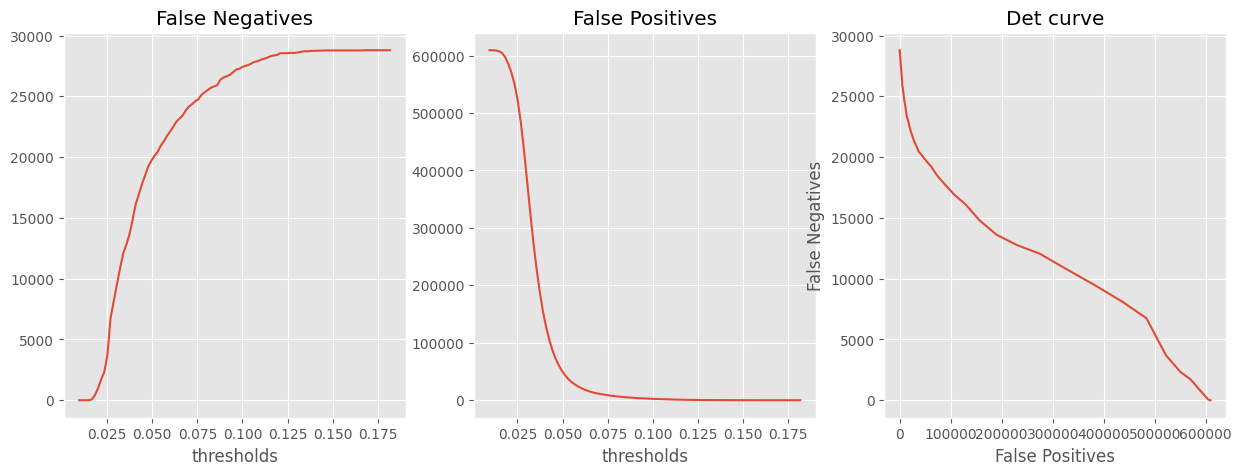

In [14]:
metrics.plot_errors_curve(cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5))

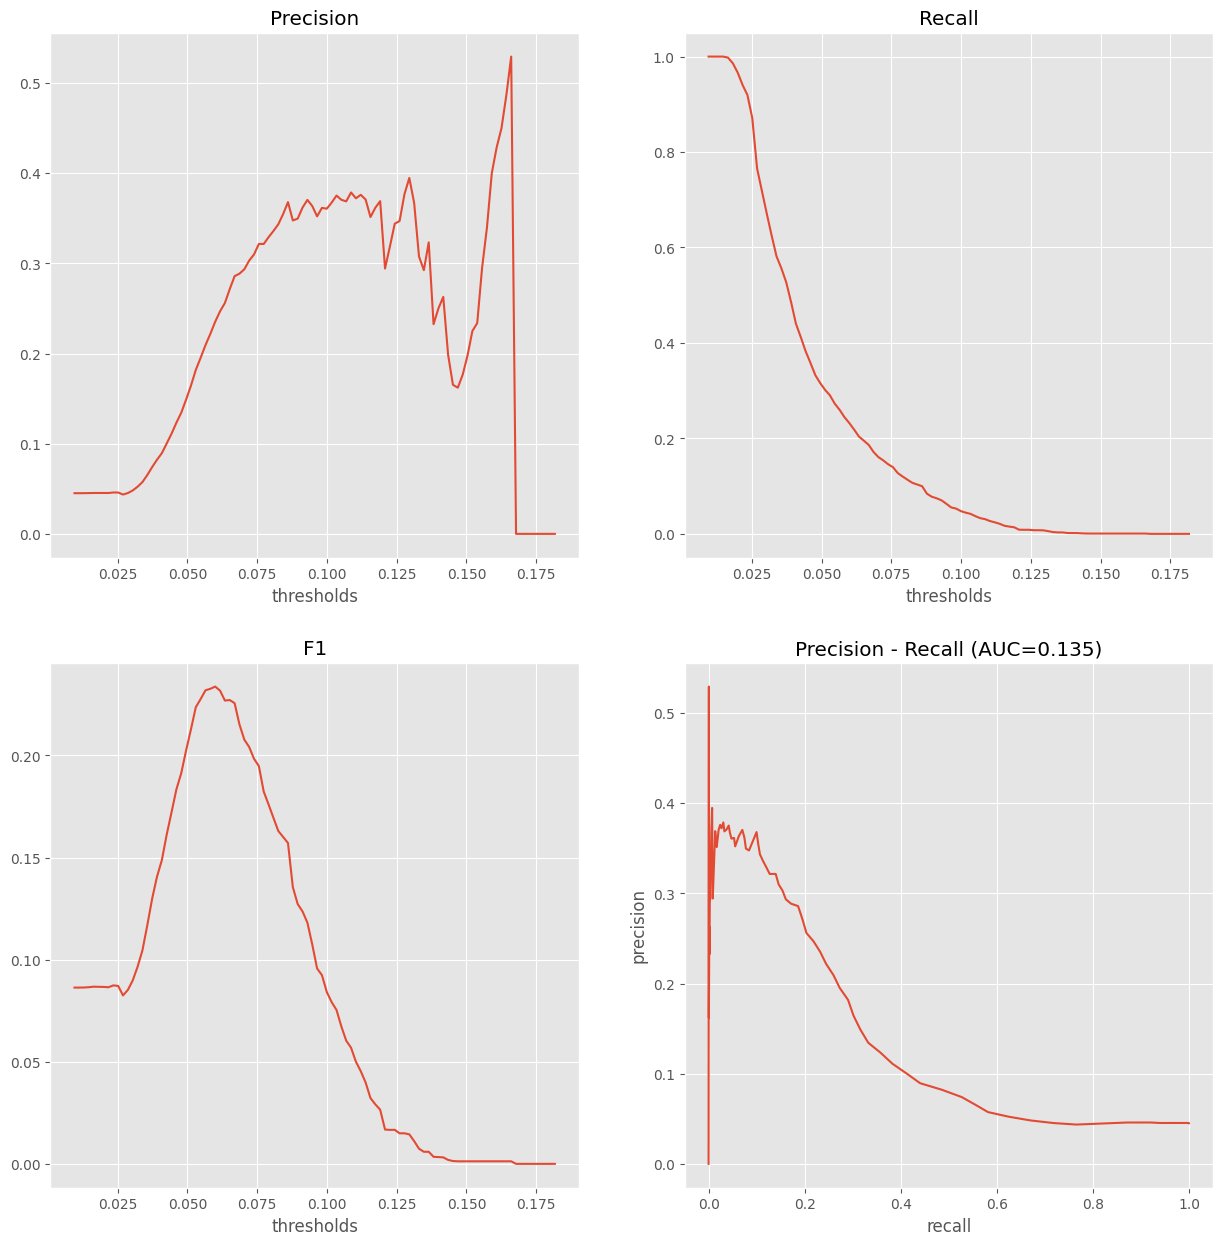

In [15]:
metrics.plot_precision_recall_f1_curve(cmodel.precision, cmodel.recall, cmodel.f1_score, cmodel.thresholds)

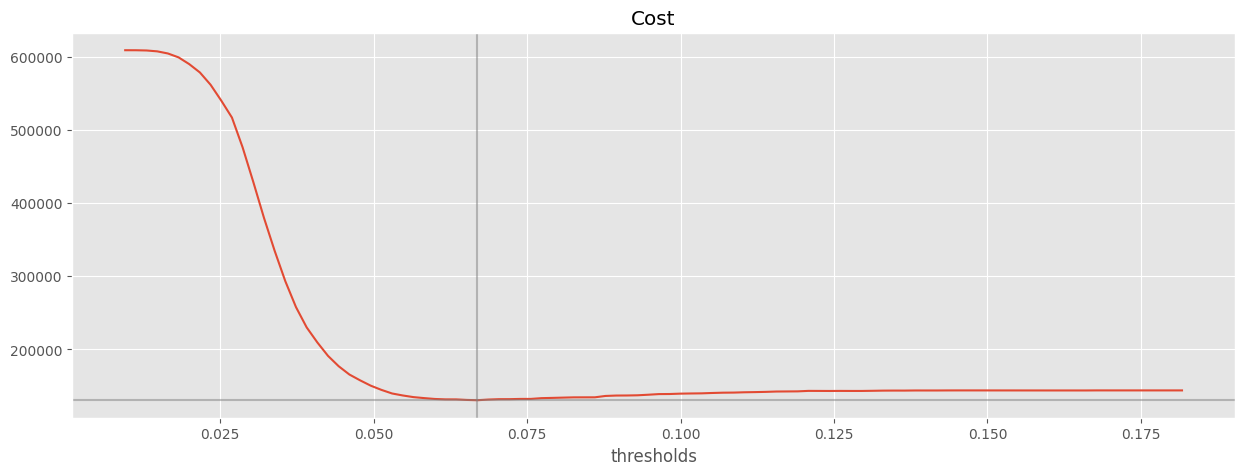

In [16]:
metrics.plot_cost(cmodel)